In [1]:
%matplotlib inline

from datasets import load_dataset, load_from_disk
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import pandas as pd

/home/ubuntu/miniconda3/envs/handbook/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
ds = load_from_disk("/home/ubuntu/hieu.nn/Lang/alignment-handbook/data/spin_analyze/zephyr-7b-sft-full-SPIN-iter0/SPIN_iter0/0_1000")
ref_ds = load_from_disk("/home/ubuntu/hieu.nn/Lang/alignment-handbook/data/spin_analyze/zephyr-7b-sft-full/SPIN_iter0/0_1000")

In [3]:
tokenizer = AutoTokenizer.from_pretrained("UCLA-AGI/zephyr-7b-sft-full-SPIN-iter0")

In [11]:
def apply_chat_template(example, tokenizer, ):
    messages = example['generated']
    if messages[0]["role"] != "system":
        messages.insert(0, {"role": "system", "content": ""})
    example['text_generated'] = tokenizer.apply_chat_template(messages[:3], tokenize=False, add_generation_prompt=False)
    messages = example['real']
    if messages[0]["role"] != "system":
        messages.insert(0, {"role": "system", "content": ""})
    example['text_real'] = tokenizer.apply_chat_template(messages[:3], tokenize=False, add_generation_prompt=False)
    example['text_prompt'] = tokenizer.apply_chat_template(messages[:2], tokenize=False, add_generation_prompt=False)

    return example

def preprocess(example):
    example = apply_chat_template(example, tokenizer)
    example['prompt_token_length'] = len(tokenizer(example['text_prompt'])['input_ids'])

    example['generated_response_logprobs'] = sum(example['generated_logprobs'][example['prompt_token_length']:])
    example['real_response_logprobs'] = sum(example['real_logprobs'][example['prompt_token_length']:])
    example['generated_length'] = len(tokenizer(example['text_generated'])['input_ids']) - example['prompt_token_length']
    example['real_length'] = len(tokenizer(example['text_real'])['input_ids']) - example['prompt_token_length']
    # example['reward'] = 
    return example


In [12]:
processed_ds = ds.map(preprocess)
processed_ref_ds = ref_ds.map(preprocess)

Map: 100%|██████████| 1000/1000 [00:02<00:00, 415.24 examples/s]


In [16]:
data = []
for example, ref_example in zip(processed_ds, processed_ref_ds):
    data.append((example['generated_response_logprobs'] - ref_example['generated_response_logprobs'], example['generated_length'], 'generated'))
    data.append((example['real_response_logprobs'] - ref_example['real_response_logprobs'], example['real_length'], 'real'))
data = pd.DataFrame(data, columns=['reward', 'length', 'type'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


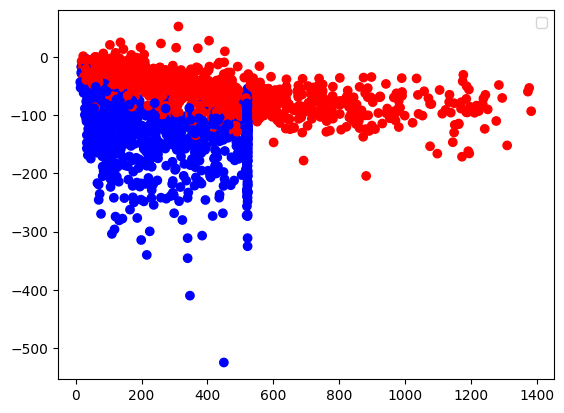

In [18]:
plt.scatter(data['length'], data['reward'], c=data['type'].map({'generated': 'blue', 'real': 'red'}))
plt.legend()

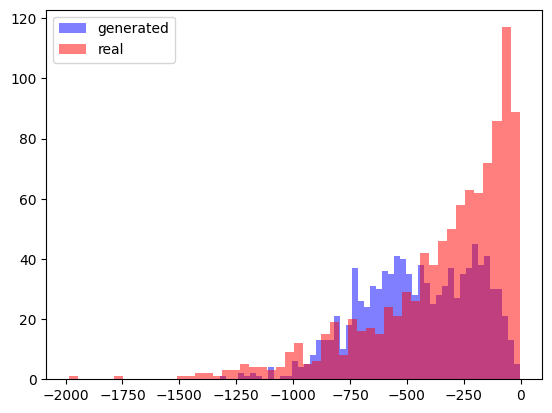

In [25]:
plt.hist(data[data['type'] == 'generated']['logprobs'], bins=50, alpha=0.5, color='blue', label='generated')
plt.hist(data[data['type'] == 'real']['logprobs'], bins=50, alpha=0.5, color='red', label='real')
plt.legend()